### 0. Imports and setup

In [1]:
from src.dataset import Colored3DMNIST, DataLoader
from torchvision import transforms, datasets
from IPython.display import clear_output
from matplotlib.colors import rgb2hex
from src.nn import UNet, ResNet_D
from src.plot import plot_img
from pathlib import Path
from tqdm import tqdm

import torch.nn.functional as F
import matplotlib.pyplot as plt
import src.data as data
import torch.nn as nn
import numpy as np
import torchvision
import torch
import gc

In [2]:
if torch.cuda.is_available():
    torch.cuda.set_device(f"cuda:0")
torch.manual_seed(42)
np.random.seed(42)

### 1. Getting the data ready

In [3]:
BATCH_SIZE = 32

def random_color(im):
    hue = np.random.choice([60, 120, 240, 280])
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6    
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

def Add_dimension(im):
    img_3D = torch.zeros(im.shape[0], im.shape[1], im.shape[2], 16)
    for i in range(im.shape[1]):
      if i < 4 or i > 12:
        img_3D[:, :, :, i] = torch.zeros_like(im)
      else:
        img_3D[:, :, :, i] = im
    return img_3D 

TRANSFORM_3D = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    random_color,
    Add_dimension,
])

# Load train datasets
mnist_train_a = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)

indices = mnist_train_a.targets == 3
mnist_train_a.data, mnist_train_a.targets = mnist_train_a.data[indices], mnist_train_a.targets[indices]

mnist_loader_a = torch.utils.data.DataLoader(mnist_train_a, batch_size=BATCH_SIZE, shuffle=True)


mnist_train_b = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)

indices = mnist_train_b.targets == 5
mnist_train_b.data, mnist_train_b.targets = mnist_train_b.data[indices], mnist_train_b.targets[indices]

mnist_loader_b = torch.utils.data.DataLoader(mnist_train_b, batch_size=BATCH_SIZE, shuffle=True)


mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM_3D)

indices = mnist_test.targets == 3
mnist_test.data, mnist_test.targets = mnist_test.data[indices], mnist_test.targets[indices]

mnist_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True)

Let's plot a number:

In [4]:
def plot_img(img):
    fig = plt.figure()
    ax = plt.axes(projection="3d")

    color = np.array([rgb2hex(rgb) for rgb in img.numpy().reshape(3, -1).T])
    color = color.reshape(*img.shape[1:])
    
    if torch.any(img[0, ...]):
        img = img[0, ...]
    elif torch.any(img[1, ...]):
        img = img[1, ...]
    else:
        img = img[2, ...]
    
    ax.voxels(img, facecolors=color)
    plt.show()


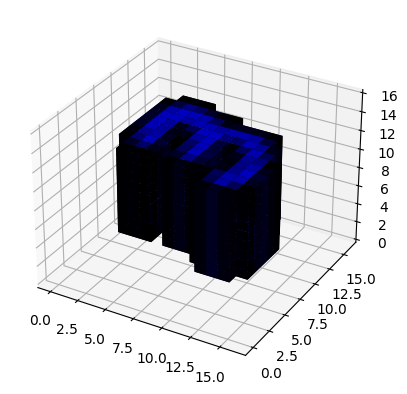

In [5]:
plot_img(next(iter(mnist_train_a))[0])

### 3. Preparation for the training

In [6]:
# Taken from https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/src/tools.py
def weights_init_D(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        
def weights_init_mlp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

In [7]:
f = ResNet_D(16, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3).cuda()

In [8]:
iter_train_a = iter(mnist_loader_a)
iter_train_b = iter(mnist_loader_b)
iter_test = iter(mnist_loader_test)

def sample_train_a():
    global mnist_loader_a, iter_train_a
    try:
        return next(iter_train_a)[0]
    except StopIteration:
        iter_train_a = iter(mnist_loader_a)
        return next(iter_train_a)[0]

def sample_train_b():
    global mnist_loader_b, iter_train_b
    try:
        return next(iter_train_b)[0]
    except StopIteration:
        iter_train_b = iter(mnist_loader_b)
        return next(iter_train_b)[0]

def sample_test():
    global mnist_loader_test, iter_test
    try:
        return next(iter_test)[0]
    except StopIteration:
        iter_test = iter(mnist_loader_test)
        return next(iter_test)[0]

In [9]:
T_opt = torch.optim.Adam(T.parameters(), lr=1e-5, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

### 4. Training loop

In [10]:
def sq_cost(X, Y):
  return (X-Y).square().flatten(start_dim=1).mean(dim=1)

  0%|          | 0/5001 [00:00<?, ?it/s]

T_loss: 0.1713312417268753;  f_loss: 0.00858919508755207


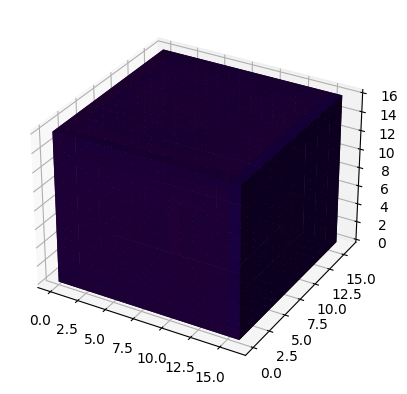

  2%|▏         | 100/5001 [01:09<56:07,  1.46it/s]

T_loss: -0.17738130688667297;  f_loss: -0.0014650672674179077


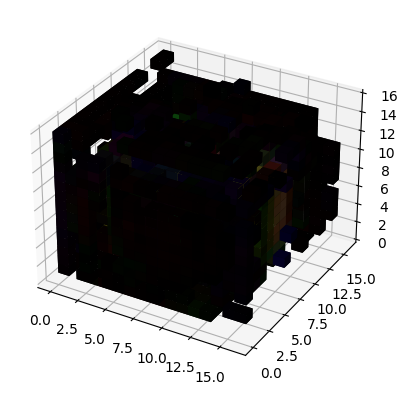

  4%|▍         | 200/5001 [02:19<55:20,  1.45it/s]  

T_loss: -0.003937389701604843;  f_loss: -0.04167327657341957


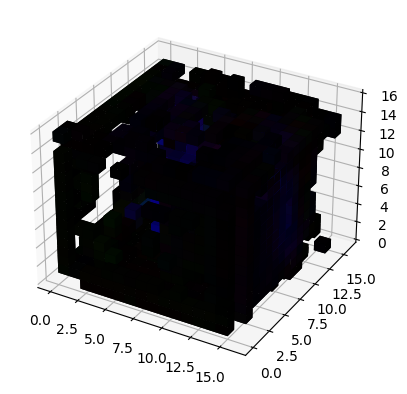

  6%|▌         | 300/5001 [03:29<54:01,  1.45it/s]  

T_loss: 0.019440405070781708;  f_loss: -0.036077044904232025


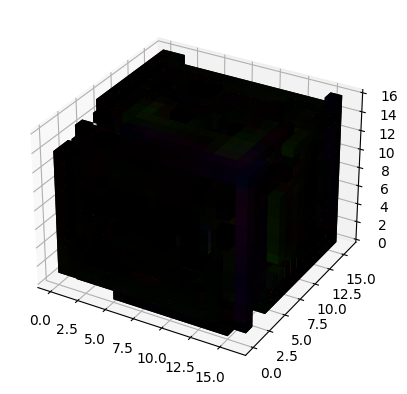

  8%|▊         | 400/5001 [04:40<53:03,  1.45it/s]  

T_loss: -0.06157917156815529;  f_loss: 0.023072078824043274


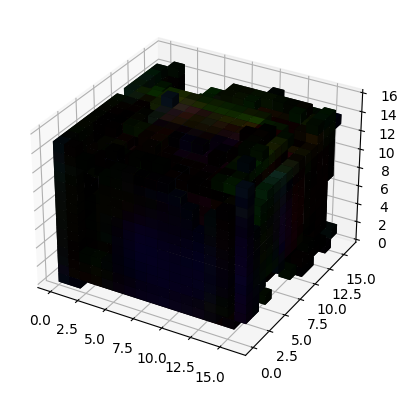

 10%|▉         | 500/5001 [05:50<51:53,  1.45it/s]  

T_loss: -0.62465900182724;  f_loss: -0.08881044387817383


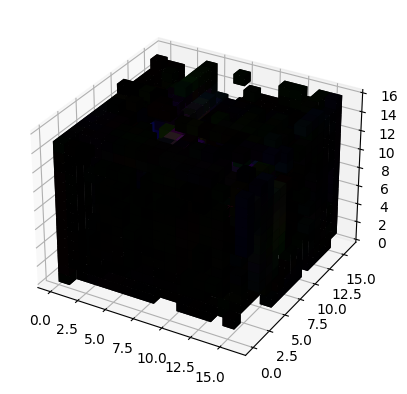

 12%|█▏        | 600/5001 [07:00<50:38,  1.45it/s]  

T_loss: 0.36964839696884155;  f_loss: -0.07143771648406982


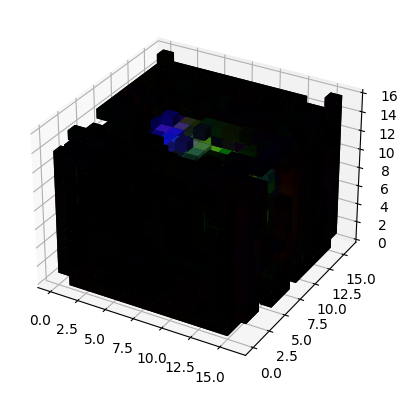

 14%|█▍        | 700/5001 [08:10<49:21,  1.45it/s]  

T_loss: -0.5137574672698975;  f_loss: 0.010834932327270508


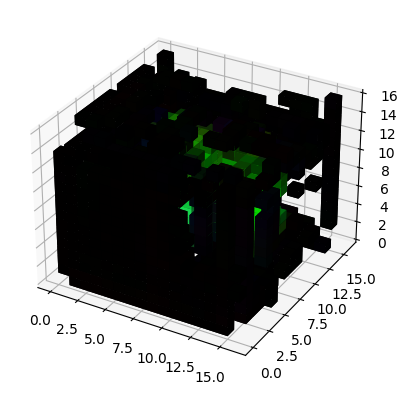

 16%|█▌        | 800/5001 [09:21<48:23,  1.45it/s]  

T_loss: -0.8057465553283691;  f_loss: -0.06670570373535156


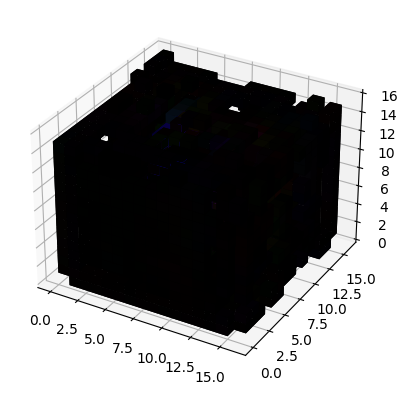

 18%|█▊        | 900/5001 [10:31<47:13,  1.45it/s]  

T_loss: 0.21090832352638245;  f_loss: -0.05185380578041077


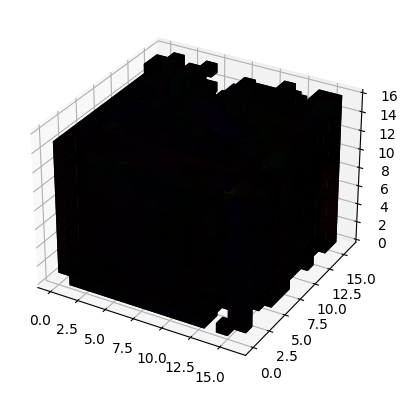

 20%|█▉        | 1000/5001 [11:41<46:01,  1.45it/s] 

T_loss: 0.011534158140420914;  f_loss: 0.00561667513102293


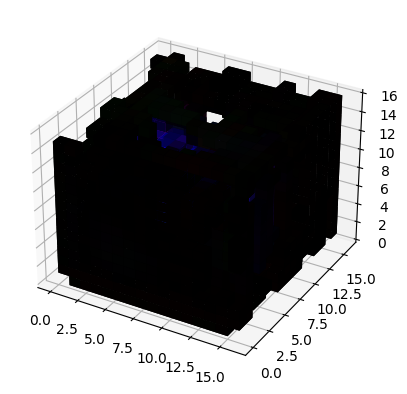

 22%|██▏       | 1100/5001 [12:52<44:38,  1.46it/s]  

T_loss: 0.3124154210090637;  f_loss: -0.029310673475265503


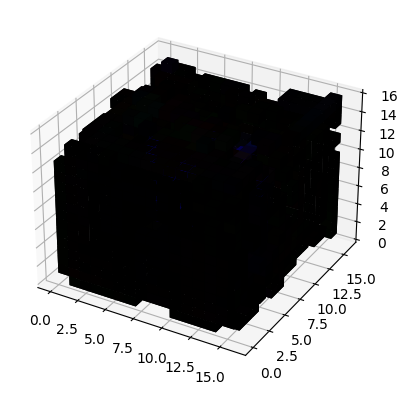

 24%|██▍       | 1200/5001 [14:02<43:46,  1.45it/s]  

T_loss: 0.02533937245607376;  f_loss: -0.0051872823387384415


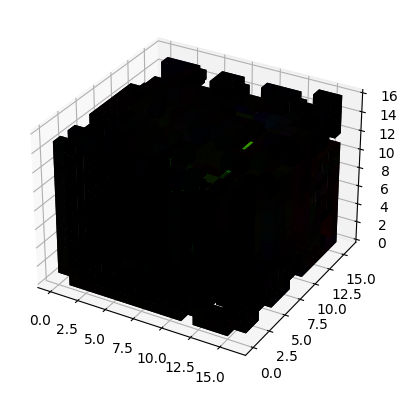

 26%|██▌       | 1300/5001 [15:13<42:38,  1.45it/s]  

T_loss: 0.24363268911838531;  f_loss: -0.009095817804336548


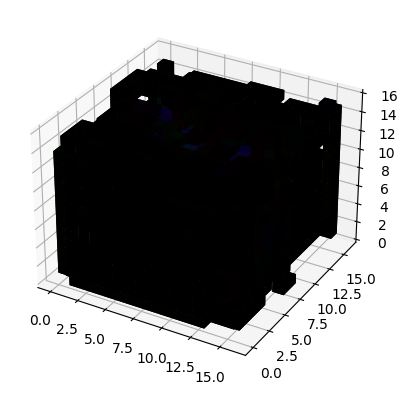

 28%|██▊       | 1400/5001 [16:23<41:24,  1.45it/s]  

T_loss: 0.035151734948158264;  f_loss: -0.010309211909770966


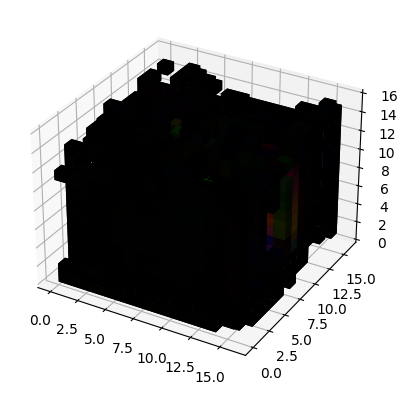

 30%|██▉       | 1500/5001 [17:34<40:20,  1.45it/s]  

T_loss: 0.031394798308610916;  f_loss: 0.009152144193649292


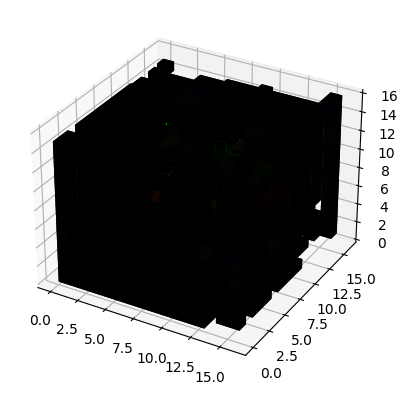

 32%|███▏      | 1600/5001 [18:44<39:10,  1.45it/s]  

T_loss: 0.0037263361737132072;  f_loss: -0.012622455134987831


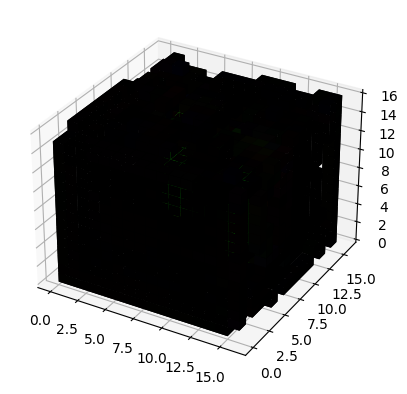

 34%|███▍      | 1700/5001 [19:54<37:36,  1.46it/s]  

T_loss: -0.03667745739221573;  f_loss: -0.0028575435280799866


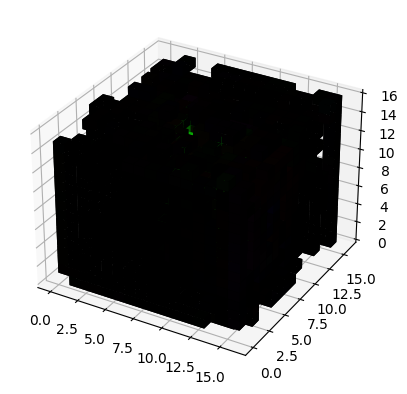

 36%|███▌      | 1800/5001 [21:05<36:47,  1.45it/s]  

T_loss: 0.03088516928255558;  f_loss: -0.0043428801000118256


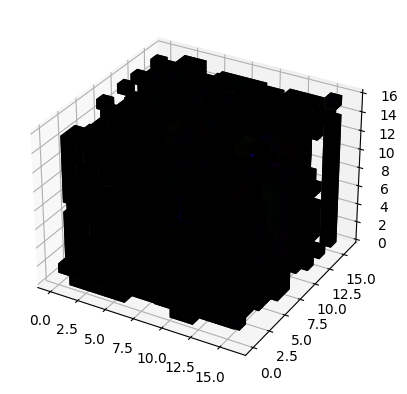

 38%|███▊      | 1900/5001 [22:15<35:42,  1.45it/s]

T_loss: 0.04827214777469635;  f_loss: -0.0013620033860206604


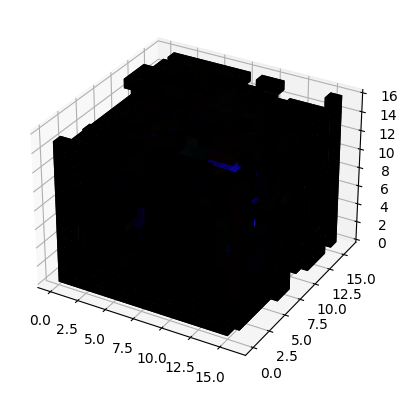

 40%|███▉      | 2000/5001 [23:26<34:35,  1.45it/s]

T_loss: 0.07334426045417786;  f_loss: -0.003859449177980423


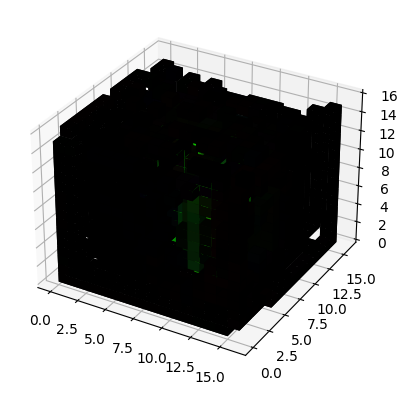

 42%|████▏     | 2100/5001 [24:36<33:20,  1.45it/s]

T_loss: 0.13045147061347961;  f_loss: 0.004005253314971924


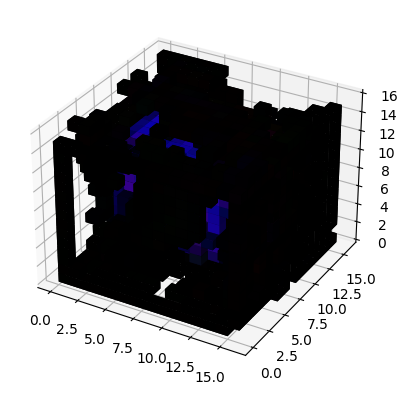

 44%|████▍     | 2200/5001 [25:46<32:00,  1.46it/s]

T_loss: 0.08046635240316391;  f_loss: 0.002645350992679596


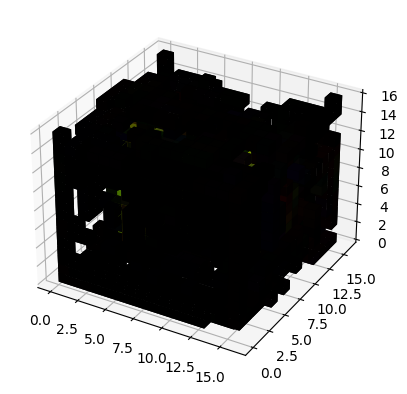

 46%|████▌     | 2300/5001 [26:56<31:06,  1.45it/s]

T_loss: 0.06350690126419067;  f_loss: 0.0004880949854850769


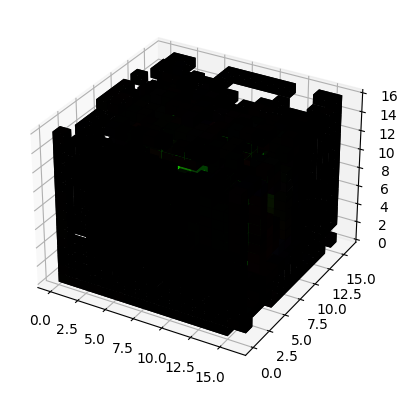

 48%|████▊     | 2400/5001 [28:07<29:57,  1.45it/s]

T_loss: 0.13492178916931152;  f_loss: 0.048043206334114075


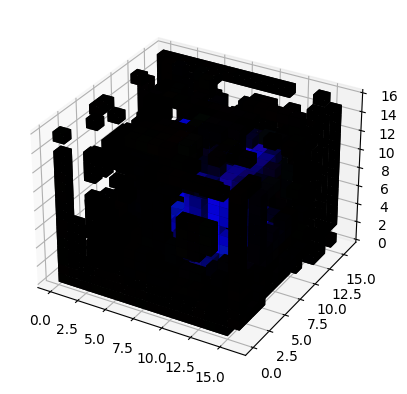

 50%|████▉     | 2500/5001 [29:17<28:47,  1.45it/s]

T_loss: 0.0813535675406456;  f_loss: 0.0129275843501091


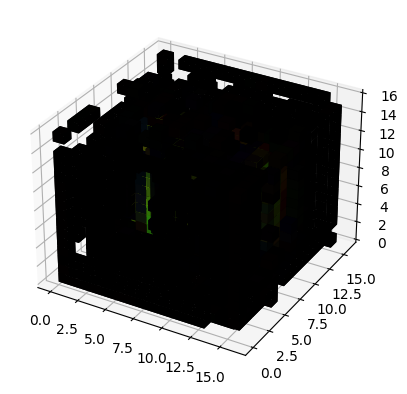

 52%|█████▏    | 2600/5001 [30:27<27:39,  1.45it/s]

T_loss: 0.038865040987730026;  f_loss: 0.0004296153783798218


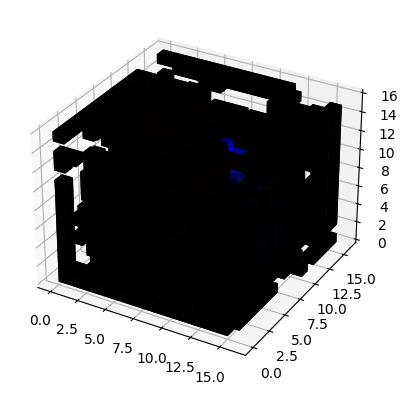

 54%|█████▍    | 2700/5001 [31:37<26:32,  1.45it/s]

T_loss: 0.06637861579656601;  f_loss: 0.028928175568580627


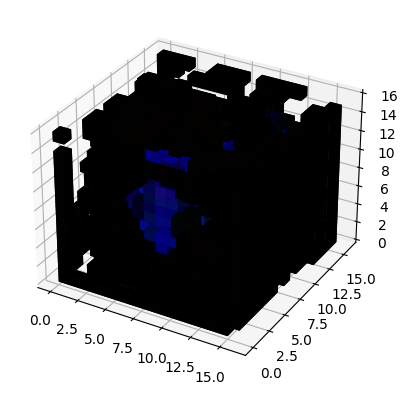

 56%|█████▌    | 2800/5001 [32:47<25:21,  1.45it/s]

T_loss: 0.030382879078388214;  f_loss: 5.2191317081451416e-05


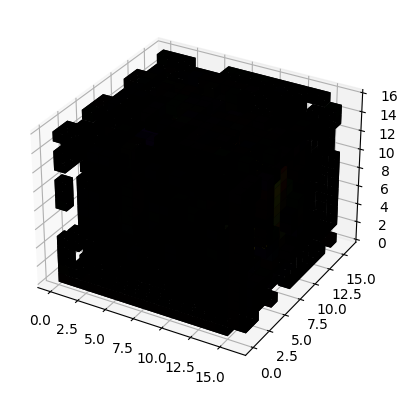

 58%|█████▊    | 2900/5001 [33:57<24:07,  1.45it/s]

T_loss: 0.06535276770591736;  f_loss: -0.013200443238019943


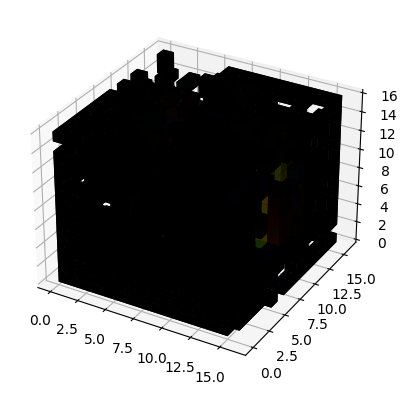

 60%|█████▉    | 3000/5001 [35:08<23:03,  1.45it/s]

T_loss: 0.1048901230096817;  f_loss: -0.00018596649169921875


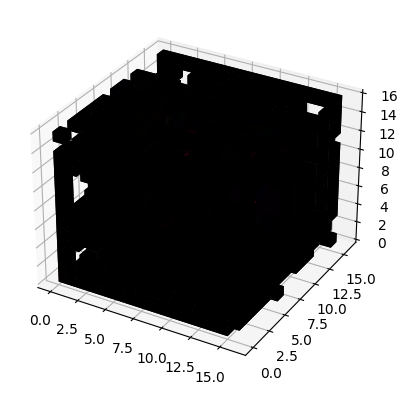

 62%|██████▏   | 3100/5001 [36:18<21:53,  1.45it/s]

T_loss: 0.04087018966674805;  f_loss: -0.0037346240133047104


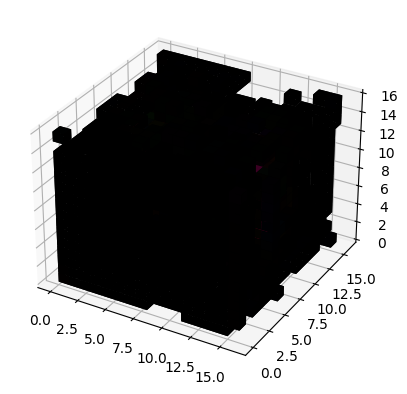

 64%|██████▍   | 3200/5001 [37:28<20:43,  1.45it/s]

T_loss: -0.0205544400960207;  f_loss: -0.007817359641194344


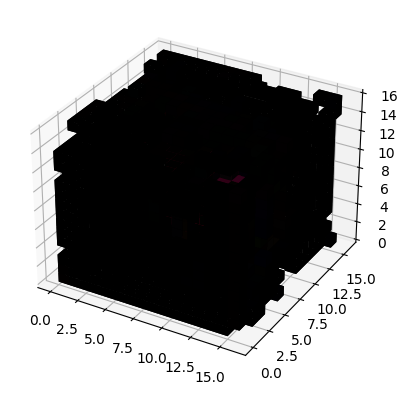

 66%|██████▌   | 3300/5001 [38:39<19:30,  1.45it/s]

T_loss: 0.021552009508013725;  f_loss: -0.0015650689601898193


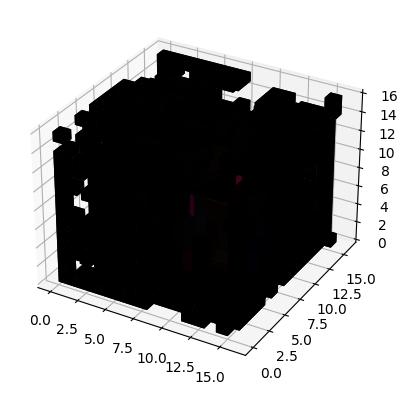

 68%|██████▊   | 3400/5001 [39:49<18:13,  1.46it/s]

T_loss: 0.052496910095214844;  f_loss: -0.010773846879601479


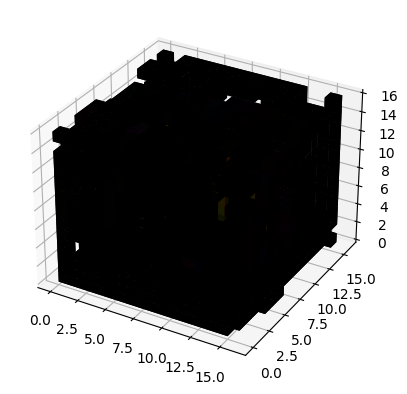

 70%|██████▉   | 3500/5001 [41:00<17:18,  1.45it/s]

T_loss: -0.13884027302265167;  f_loss: -0.0015645623207092285


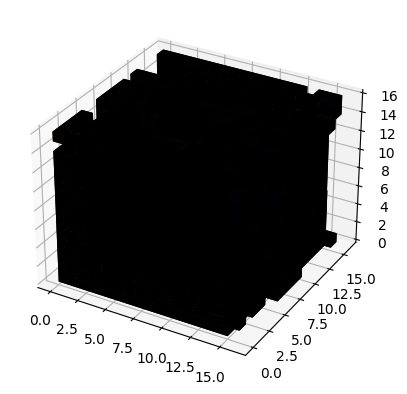

 72%|███████▏  | 3600/5001 [42:10<16:08,  1.45it/s]

T_loss: -0.11607232689857483;  f_loss: -0.010464474558830261


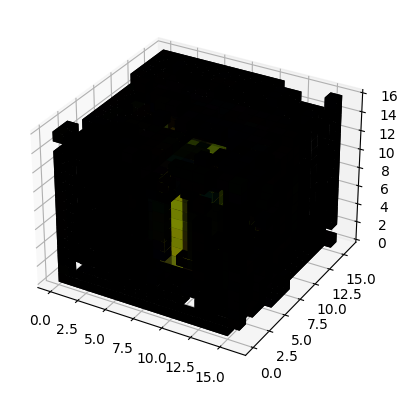

 74%|███████▍  | 3700/5001 [43:21<14:59,  1.45it/s]

T_loss: -0.17180845141410828;  f_loss: 0.00019755959510803223


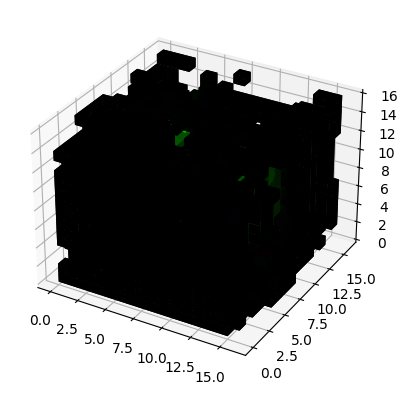

 76%|███████▌  | 3800/5001 [44:31<13:50,  1.45it/s]

T_loss: 0.020014069974422455;  f_loss: -0.038553476333618164


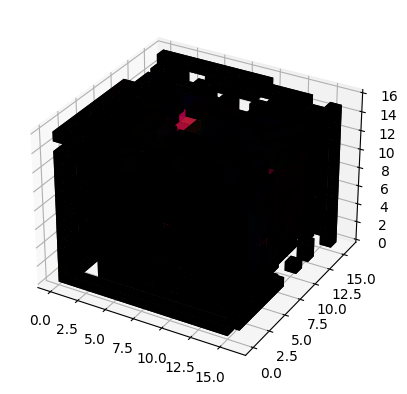

 76%|███████▌  | 3809/5001 [44:39<13:58,  1.42it/s]


KeyboardInterrupt: 

In [11]:
for step in tqdm(range(5001)):
    # clear_output(wait=True)

    # Training T, freezing f
    T.train(True)
    f.eval()
    
    for i in range(10):
        X = sample_train_a().cuda()

        T_X = T(X)
        T_loss = sq_cost(X, T_X).mean() - f(T_X).mean()
        T_opt.zero_grad()
        T_loss.backward()
        T_opt.step()
    

    # Training f, freezing T
    f.train(True)
    T.eval()

    X = sample_train_a().cuda()
    Y = sample_train_b().cuda()

    with torch.no_grad():
        T_x = T(X)
    
    f_loss = f(T_x).mean() - f(Y).mean()
    f_opt.zero_grad()
    f_loss.backward()
    f_opt.step()


    if not step % 100:
        print(f"T_loss: {T_loss}; ", end="")
        print(f" f_loss: {f_loss}")
        T_X = torch.clip(T(X)[0].cpu().detach(), min=0, max=1)
        plot_img(T_X)

    # Save OT map every 1000 steps
    if not step % 1000:
        torch.save(T.state_dict, f"weights/OT_{step}.pt")

    gc.collect()
    torch.cuda.empty_cache()

In [12]:
test_batch = sample_test()

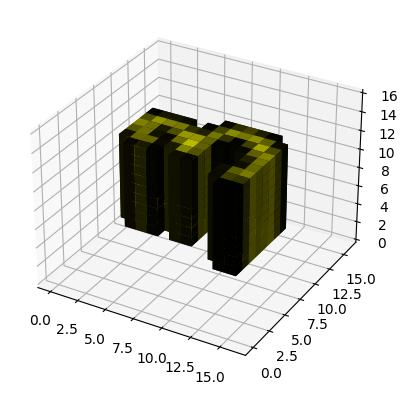

In [13]:
plot_img(test_batch[0])

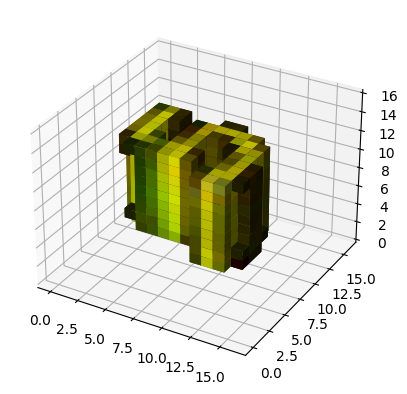

In [24]:
T_X = torch.clip(T(X)[0].cpu().detach(), min=0, max=1)
T_X[T_X < 0.1] = 0

plot_img(T_X)

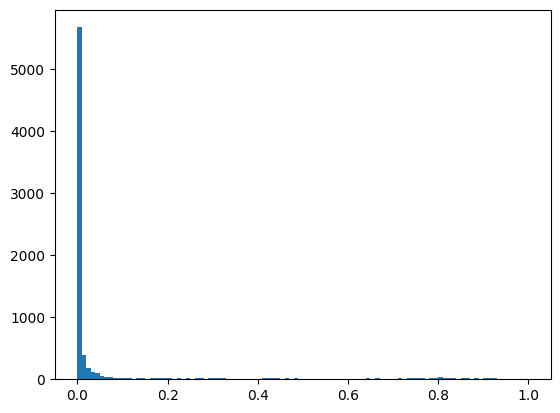

In [22]:
plt.hist(T_X.unique(), bins=100)
plt.show()

In [ ]:
T_1000 = UNet(3, 3).cuda()
checkpoint = torch.load("weights/OT_1000.pt")
T_1000.load_state_dict(checkpoint())

T_1000.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (4): Ba

In [ ]:
test_batch = next(iter(mnist_test))

/tmp/ipykernel_104064/2025946399.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


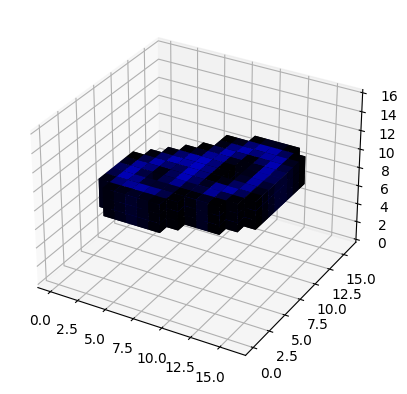

In [ ]:
plot_img(test_batch[0])